In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

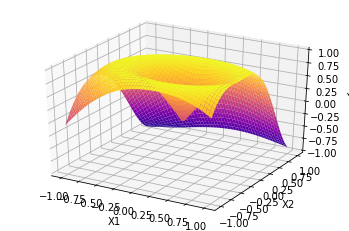

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [4]:
optimizer = tnn.Adam(0.01)
net = tnn.AutoForm(new_layers=True)
la1 = tnn.NonLinearLayer(2, 5, activation=tdnn.Relu_1Linear(), optimizer=optimizer)
la2 = tnn.NonLinearLayer(5, 5, activation=tdnn.Relu_1Linear(), optimizer=optimizer)
la3 = tnn.NonLinearLayer(5, 5, activation=tdnn.Relu_1Linear(), optimizer=optimizer)
la4 = tnn.LinearLayer(5, 1, optimizer=optimizer)

In [5]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

try:
    for epoch in range(100000):
        yout = net.forward(xx)
        dy = yout - yy
        dx = net.backward(dy)

        net.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.3192711885054297
100 Error =  0.015737396399083312
200 Error =  0.01257595934133842
300 Error =  0.012093467119480537
400 Error =  0.008809881019918342
500 Error =  0.007016333110980806
600 Error =  0.0060606712100120625
700 Error =  0.004531501187313274
800 Error =  0.0027294701480431727
900 Error =  0.0023829023220786907
1000 Error =  0.0018084266684893588
1100 Error =  0.001567001781118552
1200 Error =  0.0012803263240567264
1300 Error =  0.0011497233714703149
1400 Error =  0.0011126490412568283
1500 Error =  0.0010834333873939385
1600 Error =  0.0010666649586957959
1700 Error =  0.001091330622668137
1800 Error =  0.0010379575908151559
1900 Error =  0.0010439759176988019
2000 Error =  0.0010448054241868705
2100 Error =  0.0010102596186416187
2200 Error =  0.0009979691909628293
2300 Error =  0.0010002581628703793
2400 Error =  0.0009806150345746045
2500 Error =  0.0009729198589872503
2600 Error =  0.0010087052288922937
2700 Error =  0.001088480063273483
2800 Error =  0.0

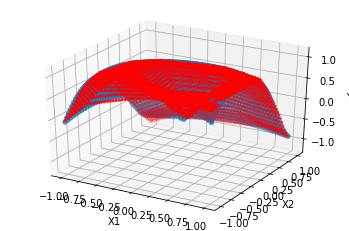

In [7]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

## Various Methods for computing the significance of Neurons

1. Magnitude of In x Out weights (Functional Approach)

-- Good for layer by layer pruning, may not do well on global pruning

In [44]:
class Significance_Magnitude:
    
    def __init__(self, layers):
        self.layers = layers
        pass
    
    def get_significance(self,):
        significance = []
        for i in range(len(self.layers)-1):
            sig = self._compute_norm_of_neurons_(self.layers[i], self.layers[i+1])
            sig = sig/sig.sum()
            significance.append(sig)
        return significance
    
    def _compute_norm_of_neurons_(self, in_layer, out_layer, order=2):
        innorm = np.linalg.norm(in_layer.weights, ord=order, axis=0)
        outnorm = np.linalg.norm(out_layer.weights, ord=order, axis=1)
        return innorm*outnorm

In [45]:
sig1 = Significance_Magnitude(net.layerList)
sig1.get_significance()

[array([0.07772492, 0.10913177, 0.24837538, 0.12972273, 0.4350452 ]),
 array([0.10588243, 0.13188045, 0.11104432, 0.49181515, 0.15937765]),
 array([0.0520108 , 0.20604153, 0.23862275, 0.27563377, 0.22769115])]

2. Neuron Importance Score Propagation (NISP):    
    Propagate importance backwards by absolute weight (Functional Approach)   
    The importance score (Data Approach) can be computed based on Data. 
    
    -- This does not consider the significance lost if some neuron fires less (or dead)

In [46]:
class Significance_NISP:
    
    def __init__(self, layers):
        self.layers = layers
        pass
    
    def get_significance(self,):
        ### the significance of all output units are considered unit
        significance = []
        sig_prev = np.ones([1,self.layers[-1].weights.shape[1]])
        for i in reversed(range(1, len(self.layers))):
            fac_i = np.abs(self.layers[i].weights).T
            sig_i = sig_prev @ fac_i
            sig_prev = sig_i
            significance.append(sig_i)
        significance.reverse()
        return significance

In [47]:
sig2 = Significance_NISP(net.layerList)
sig2.get_significance()

[array([[ 7.41748408,  9.88076917,  7.61408536, 11.92208879, 28.47424803]]),
 array([[1.99794614, 5.51454907, 4.08658457, 4.21560704, 1.89157638]]),
 array([[0.40215528, 1.09390355, 1.28305598, 1.30976064, 1.99889507]])]

3. Average of activation of neuron as score for Importance (Data Approach)

-- The activation might be scaled by small weight, which is not considered here,   
        so does not give the accurate picture of the Importance

In [48]:
class Significance_AverageActivation:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.average_activation = None
        pass
    
    def _compute_average_activation_(self):
        self.average_activation = [0]*(len(self.layers)-1)
        data_size = len(self.dataX)
        if self.batch_size is None:
            self.batch_size = data_size
        
        start = np.arange(0, data_size, self.batch_size)
        stop = start+self.batch_size
        if stop[-1]>data_size:
            stop[-1] = data_size
            
        for idx in range(len(start)):
            activations = self.dataX[start[idx]:stop[idx]]
            for i in range(len(self.layers)-1):
                activations = self.layers[i].forward(activations)
                sum_actv = np.abs(activations).sum(axis=0)
                self.average_activation[i] += sum_actv
        for i in range(len(self.average_activation)):
            self.average_activation[i] /= data_size
        pass
    
    def get_significance(self,):
        self._compute_average_activation_()
        return self.average_activation

In [49]:
sig3 = Significance_AverageActivation(net.layerList, xx)
sig3.get_significance()

[array([0.68103468, 0.35682758, 1.05565851, 0.74076127, 0.06321703]),
 array([0.76233411, 0.27864092, 0.96785566, 0.32645179, 0.        ]),
 array([0.54971343, 0.6096971 , 0.06591606, 0.07900393, 0.04257272])]

4. Average percentage of Zeros/(Non-Zeros) as inverse score of Importance (Data Approach)   
    This is only useful for ReLU network
    
    -- This also does not consider following weights.

In [50]:
class Significance_APoNZ:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.average_activation = None
        pass
    
    def _compute_probability_of_non_zero_activation_(self):
        self.average_activation = [0]*(len(self.layers)-1)
        data_size = len(self.dataX)
        if self.batch_size is None:
            self.batch_size = data_size
        
        start = np.arange(0, data_size, self.batch_size)
        stop = start+self.batch_size
        if stop[-1]>data_size:
            stop[-1] = data_size
            
        for idx in range(len(start)):
            activations = self.dataX[start[idx]:stop[idx]]
            for i in range(len(self.layers)-1):
                activations = self.layers[i].forward(activations)
                sum_actv = (activations > 0).astype(float).sum(axis=0)
                self.average_activation[i] += sum_actv
        for i in range(len(self.average_activation)):
            self.average_activation[i] /= data_size
        pass
    
    def get_significance(self,):
        self._compute_probability_of_non_zero_activation_()
        return self.average_activation

In [51]:
sig4 = Significance_APoNZ(net.layerList, xx)
sig4.get_significance()

[array([0.7288, 0.5504, 0.6812, 0.7532, 0.1996]),
 array([0.9988, 0.6652, 1.    , 0.758 , 0.    ]),
 array([0.9116, 0.8916, 0.2212, 0.3892, 0.4176])]

5. Oracle Pruning: |Mean => Activation x Gradient |. Prune least valued one. (Data Approach)

-- Based on taylor approximation of Oracle Pruning.. This method is good for ReLU

In [52]:
class Significance_Oracle:
    
    def __init__(self, layers, dataX, dataY, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.dataY = dataY
        self.batch_size = batch_size
        self.oracle_abs = None
        pass
    
    def _compute_oracle_abs_(self):
        self.oracle_abs = [0]*(len(self.layers)-1)
        data_size = len(self.dataX)
        if self.batch_size is None:
            self.batch_size = data_size
        
        start = np.arange(0, data_size, self.batch_size)
        stop = start+self.batch_size
        if stop[-1]>data_size:
            stop[-1] = data_size
            
        for idx in range(len(start)):
            activations = self.dataX[start[idx]:stop[idx]]
            for i in range(len(self.layers)):
                activations = self.layers[i].forward(activations)
            
            del_actv = activations - self.dataY
            for i in reversed(range(len(self.layers))):
                del_actv = self.layers[i].backward(del_actv)
            
            for i in range(len(self.layers)-1):
#                 sum_oracle = (self.layers[i].zee * self.layers[i].del_zee).sum(axis=0)
                sum_oracle = (self.layers[i].output * self.layers[i].del_output).sum(axis=0)
                self.oracle_abs[i] += sum_oracle
        
        global_sum = 0
        for i in range(len(self.oracle_abs)):
            self.oracle_abs[i] = np.abs(self.oracle_abs[i]/data_size)
            global_sum += self.oracle_abs[i].sum()
        for i in range(len(self.oracle_abs)):
            self.oracle_abs[i] = self.oracle_abs[i]/global_sum*len(self.oracle_abs)
            
#             self.oracle_abs[i] /= np.linalg.norm(self.oracle_abs[i], ord=2)
            
        pass
    
    def get_significance(self,):
        self._compute_oracle_abs_()
        return self.oracle_abs

In [53]:
sig5 = Significance_Oracle(net.layerList, xx, yy)
sig5.get_significance()

[array([0.09961124, 0.08237505, 0.23081214, 0.32067818, 0.05305324]),
 array([0.04761806, 0.59512719, 0.81841567, 0.0301684 , 0.        ]),
 array([0.16459264, 0.38800107, 0.01232416, 0.06924054, 0.08798242])]

6. Mix 2&3 : The importance score propagation only look at weights (backward propagation),    
    The activation average (or APoNZ) only look at data (forward propagation).   
    Combining will give more effective measure: |meanAct x ImpScore|           

In [54]:
class Significance_ScaledNISP:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.average_activation = None
        pass
    
    def get_significance(self,):
        actv_sig = Significance_AverageActivation(self.layers, self.dataX, self.batch_size)
#         actv_sig = Significance_APoNZ(self.layers, self.dataX, self.batch_size)
        self.average_activation = actv_sig.get_significance()
        significance = []
        
        sig_prev = np.ones([1,self.layers[-1].weights.shape[1]])
        for i in reversed(range(1, len(self.layers))):
            fac_i = np.abs(self.layers[i].weights).T
            sig_i = sig_prev @ fac_i
            sig_i = sig_i * self.average_activation[i-1].reshape(1,-1)
            sig_prev = sig_i
            significance.append(sig_i)
        
        significance.reverse()
        return significance
#         return self.average_activation

In [55]:
sig6 = Significance_ScaledNISP(net.layerList, xx)
sig6.get_significance()

[array([[0.46544653, 0.40997321, 0.63066968, 0.89952923, 0.14880664]]),
 array([[0.19340283, 0.37083746, 0.84279056, 0.33127455, 0.        ]]),
 array([[0.22107016, 0.66694982, 0.08457399, 0.10347624, 0.08509841]])]

In [56]:
sig6.average_activation

[array([0.68103468, 0.35682758, 1.05565851, 0.74076127, 0.06321703]),
 array([0.76233411, 0.27864092, 0.96785566, 0.32645179, 0.        ]),
 array([0.54971343, 0.6096971 , 0.06591606, 0.07900393, 0.04257272])]

In [57]:
### If a neuron always fires_, then it is also useless, this is not given by any method.
# sig = min(Average_Firing, 1-Average_Firing)
# Use of DoubleRelu Activation Function might give better,, but it degrades performance
# OR use sig (above) * AverageNonZeroActivation,, but it needs immediate layer correction

In [58]:
class Significance_AverageActiveDivision:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.average_activation = None
        self.count_activation = None
        self.significance = None
        pass
    
    def _compute_complicated_value_(self):
        self.average_activation = [0]*(len(self.layers)-1)
        self.count_activation = [0]*(len(self.layers)-1)
        data_size = len(self.dataX)
        if self.batch_size is None:
            self.batch_size = data_size
        
        start = np.arange(0, data_size, self.batch_size)
        stop = start+self.batch_size
        if stop[-1]>data_size:
            stop[-1] = data_size
            
        for idx in range(len(start)):
            activations = self.dataX[start[idx]:stop[idx]]
            for i in range(len(self.layers)-1):
                activations = self.layers[i].forward(activations)
#                 sum_actv = activations.sum(axis=0)
                sum_actv = np.abs(self.layers[i].zee).sum(axis=0)
                self.average_activation[i] += sum_actv

                actv_count = np.count_nonzero(activations, axis=0)
                self.count_activation[i] += actv_count
        
        self.significance = [0]*(len(self.layers)-1)
        for i in range(len(self.average_activation)):
#             self.average_activation[i] /= self.count_activation[i]
            self.average_activation[i] /= data_size
            prob_actv = self.count_activation[i]/data_size
            prob_actv = np.minimum(prob_actv, 1-prob_actv)
            self.significance[i] = self.average_activation[i]*prob_actv
        pass
    
    def get_significance(self,):
        self._compute_complicated_value_()
        return self.significance

In [59]:
sig7 = Significance_AverageActiveDivision(net.layerList, xx) ## with mean(absolute(pre-activation))
sig7.get_significance()

[array([0.        , 0.27449368, 0.41622648, 0.21128627, 0.20222607]),
 array([0.        , 0.11067939, 0.        , 0.15549243, 0.        ]),
 array([0.        , 0.06767635, 0.09788889, 0.20231477, 0.04150462])]

In [60]:
sig4.get_significance()

[array([0.7288, 0.5504, 0.6812, 0.7532, 0.1996]),
 array([0.9988, 0.6652, 1.    , 0.758 , 0.    ]),
 array([0.9116, 0.8916, 0.2212, 0.3892, 0.4176])]

In [61]:
# Combining Average Active Division with NISP
class Significance_ScaledNISP_2:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.average_activation = None
        pass
    
    def get_significance(self,):
        actv_sig = Significance_AverageActiveDivision(self.layers, self.dataX, self.batch_size)
        self.average_activation = actv_sig.get_significance()
        significance = []
        
        sig_prev = np.ones([1,self.layers[-1].weights.shape[1]])
        for i in reversed(range(1, len(self.layers))):
            fac_i = np.abs(self.layers[i].weights).T
            sig_i = sig_prev @ fac_i
            sig_i = sig_i * self.average_activation[i-1].reshape(1,-1)
            sig_prev = sig_i
            significance.append(sig_i)
        
        significance.reverse()
        return significance
#         return self.average_activation

In [62]:
sig8 = Significance_ScaledNISP_2(net.layerList, xx)
sig8.get_significance()

[array([[0.        , 0.01038944, 0.0069154 , 0.01512526, 0.08526894]]),
 array([[0.        , 0.03976226, 0.        , 0.08297244, 0.        ]]),
 array([[0.        , 0.0740314 , 0.12559692, 0.26498392, 0.08296339]])]

In [63]:
#### We need one linear to perserve the information in the dead zone... 
#### maybe the almost all activation is perserving the information (maybe not)
#### This will be clear if we always add one linear unit to the activation

My Importance --> Similar to Oracle Pruning and NIPS. 

The Oracle Pruning method computes gradient based on error.   
We need to compute gradient based on the output variable instead.   
The importance propagates significance based on significance of last units. They can take values other than default of 1s.

In [64]:
class Significance_InVal_x_OutSlope:
    
    def __init__(self, layers, dataX, batch_size=None):
        self.layers = layers
        self.dataX  = dataX
        self.batch_size = batch_size
        self.importance = None
        pass
    
    def _compute_importance_(self):
        self.importance = [0]*(len(self.layers)-1)
        data_size = len(self.dataX)
        if self.batch_size is None:
            self.batch_size = data_size
        
        start = np.arange(0, data_size, self.batch_size)
        stop = start+self.batch_size
        if stop[-1]>data_size:
            stop[-1] = data_size
            
        for idx in range(len(start)):
            activations = self.dataX[start[idx]:stop[idx]]
            for i in range(len(self.layers)):
                activations = self.layers[i].forward(activations)
            
            del_actv = np.ones_like(activations)
            for i in reversed(range(len(self.layers))):
                del_actv = self.layers[i].backward(del_actv)
            
            for i in range(len(self.layers)-1):
#                 sum_oracle = (self.layers[i].zee * self.layers[i].del_zee).sum(axis=0)
                sum_import = np.abs(self.layers[i].output * self.layers[i].del_output).sum(axis=0)
                self.importance[i] += sum_import
        
        for i in range(len(self.importance)):
            self.importance[i] = self.importance[i]/data_size
            
        pass
    
    def get_significance(self,):
        self._compute_importance_()
        return self.importance

In [65]:
sig9 = Significance_InVal_x_OutSlope(net.layerList, xx)
sig9.get_significance()

[array([0.44950489, 0.62195049, 0.50575936, 0.63468778, 0.05574923]),
 array([0.24083794, 0.69434571, 1.22234954, 0.24491612, 0.        ]),
 array([0.22107016, 0.66694982, 0.08457399, 0.10347624, 0.08509841])]

### Comparing all significances

In [66]:
## Magnitude
sig1.get_significance()

[array([0.07772492, 0.10913177, 0.24837538, 0.12972273, 0.4350452 ]),
 array([0.10588243, 0.13188045, 0.11104432, 0.49181515, 0.15937765]),
 array([0.0520108 , 0.20604153, 0.23862275, 0.27563377, 0.22769115])]

In [67]:
## NISP
sig2.get_significance()

[array([[ 7.41748408,  9.88076917,  7.61408536, 11.92208879, 28.47424803]]),
 array([[1.99794614, 5.51454907, 4.08658457, 4.21560704, 1.89157638]]),
 array([[0.40215528, 1.09390355, 1.28305598, 1.30976064, 1.99889507]])]

In [68]:
## aveage activation
sig3.get_significance()

[array([0.68103468, 0.35682758, 1.05565851, 0.74076127, 0.06321703]),
 array([0.76233411, 0.27864092, 0.96785566, 0.32645179, 0.        ]),
 array([0.54971343, 0.6096971 , 0.06591606, 0.07900393, 0.04257272])]

In [69]:
## Average firing
sig4.get_significance()

[array([0.7288, 0.5504, 0.6812, 0.7532, 0.1996]),
 array([0.9988, 0.6652, 1.    , 0.758 , 0.    ]),
 array([0.9116, 0.8916, 0.2212, 0.3892, 0.4176])]

In [70]:
## Oracle
sig5.get_significance()

[array([0.09961124, 0.08237505, 0.23081214, 0.32067818, 0.05305324]),
 array([0.04761806, 0.59512719, 0.81841567, 0.0301684 , 0.        ]),
 array([0.16459264, 0.38800107, 0.01232416, 0.06924054, 0.08798242])]

In [71]:
## Mix 2&3
sig6.get_significance()

[array([[0.46544653, 0.40997321, 0.63066968, 0.89952923, 0.14880664]]),
 array([[0.19340283, 0.37083746, 0.84279056, 0.33127455, 0.        ]]),
 array([[0.22107016, 0.66694982, 0.08457399, 0.10347624, 0.08509841]])]

In [72]:
## Average Active Division (Always firing neuron has 0 importance)
sig7.get_significance()

[array([0.        , 0.27449368, 0.41622648, 0.21128627, 0.20222607]),
 array([0.        , 0.11067939, 0.        , 0.15549243, 0.        ]),
 array([0.        , 0.06767635, 0.09788889, 0.20231477, 0.04150462])]

In [75]:
## NISP with Average Active Division
sig8.get_significance()

[array([[0.        , 0.01038944, 0.0069154 , 0.01512526, 0.08526894]]),
 array([[0.        , 0.03976226, 0.        , 0.08297244, 0.        ]]),
 array([[0.        , 0.0740314 , 0.12559692, 0.26498392, 0.08296339]])]

In [76]:
## Activation x Derivative wrt Y
sig9.get_significance()

[array([0.44950489, 0.62195049, 0.50575936, 0.63468778, 0.05574923]),
 array([0.24083794, 0.69434571, 1.22234954, 0.24491612, 0.        ]),
 array([0.22107016, 0.66694982, 0.08457399, 0.10347624, 0.08509841])]